In [1]:
import pandas as pd
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from src.utils.metrics import event_detection_ap

# from src.utils.post_process import post_process_for_seg
import jupyter_black
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

jupyter_black.load()
plt.style.use("ggplot")

EXP_NAME = "exp056"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
cfg = load_config(RESULT_DIR)
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_3156290/2198428768.py:29: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [3]:
def nms(predictions, scores, nms_threshold):
    order = np.argsort(scores)[::-1]
    keep = []

    while order.size > 0:
        i = order[0]
        keep.append(i)
        keep_pred = predictions[[i]]
        other_preds = predictions[order]
        enough_far = np.abs(other_preds - keep_pred) > nms_threshold
        order = order[enough_far]
    return keep

In [4]:
import numpy as np
import polars as pl
from scipy.signal import find_peaks


def post_process_for_seg(
    keys: list[str], preds: np.ndarray, score_th: float = 0.01, distance: int = 5000
) -> pl.DataFrame:
    """make submission dataframe for segmentation task

    Args:
        keys (list[str]): list of keys. key is "{series_id}_{chunk_id}"
        preds (np.ndarray): (num_series * num_chunks, duration, 2)
        score_th (float, optional): threshold for score. Defaults to 0.5.

    Returns:
        pl.DataFrame: submission dataframe
    """
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    records = []
    for series_id in unique_series_ids:
        series_idx = np.where(series_ids == series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 2)

        for i, event_name in enumerate(["onset", "wakeup"]):
            this_event_preds = this_series_preds[:, i]
            steps = np.where(this_event_preds > score_th)[0]
            scores = this_event_preds[steps]

            keep = nms(steps, scores, distance)
            steps = steps[keep]
            scores = scores[keep]

            for step, score in zip(steps, scores):
                records.append(
                    {
                        "series_id": series_id,
                        "step": step,
                        "event": event_name,
                        "score": score,
                    }
                )

    if len(records) == 0:  # 一つも予測がない場合はdummyを入れる
        records.append(
            {
                "series_id": series_id,
                "step": 0,
                "event": "onset",
                "score": 0,
            }
        )

    sub_df = pl.DataFrame(records).sort(by=["series_id", "step"])
    row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
    sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
    return sub_df

In [5]:
import optuna


def objective(trial: optuna.Trial):
    score_th = 0.005
    distance = trial.suggest_int("distance", 1, 200)

    pred_df: pl.DataFrame = post_process_for_seg(
        keys, preds[:, :, [1, 2]], score_th=score_th, distance=distance
    )
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-10-29 19:45:00,690] A new study created in memory with name: no-name-d9269566-a96d-4bd8-be10-2fbe2eb00c06
[I 2023-10-29 19:45:02,968] Trial 0 finished with value: 0.7365468887494468 and parameters: {'distance': 184}. Best is trial 0 with value: 0.7365468887494468.
[I 2023-10-29 19:45:05,337] Trial 1 finished with value: 0.7422310698969097 and parameters: {'distance': 135}. Best is trial 1 with value: 0.7422310698969097.
[I 2023-10-29 19:45:07,786] Trial 2 finished with value: 0.7426443256399338 and parameters: {'distance': 74}. Best is trial 2 with value: 0.7426443256399338.
[I 2023-10-29 19:45:09,719] Trial 3 finished with value: 0.7355759925775265 and parameters: {'distance': 190}. Best is trial 2 with value: 0.7426443256399338.
[I 2023-10-29 19:45:12,828] Trial 4 finished with value: 0.726307783192603 and parameters: {'distance': 33}. Best is trial 2 with value: 0.7426443256399338.
[I 2023-10-29 19:45:14,844] Trial 5 finished with value: 0.7380296073485728 and parameters: {'

{'distance': 113}


In [6]:
# for score_th in [0.01]:
#     pred_df: pl.DataFrame = post_process_for_seg(
#         keys, preds[:, :, [1, 2]], score_th=score_th, distance=100
#     )
#     score = event_detection_ap(gt_df, pred_df.to_pandas())

#     print(f"score_th: {score_th}, score: {score}")

In [7]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

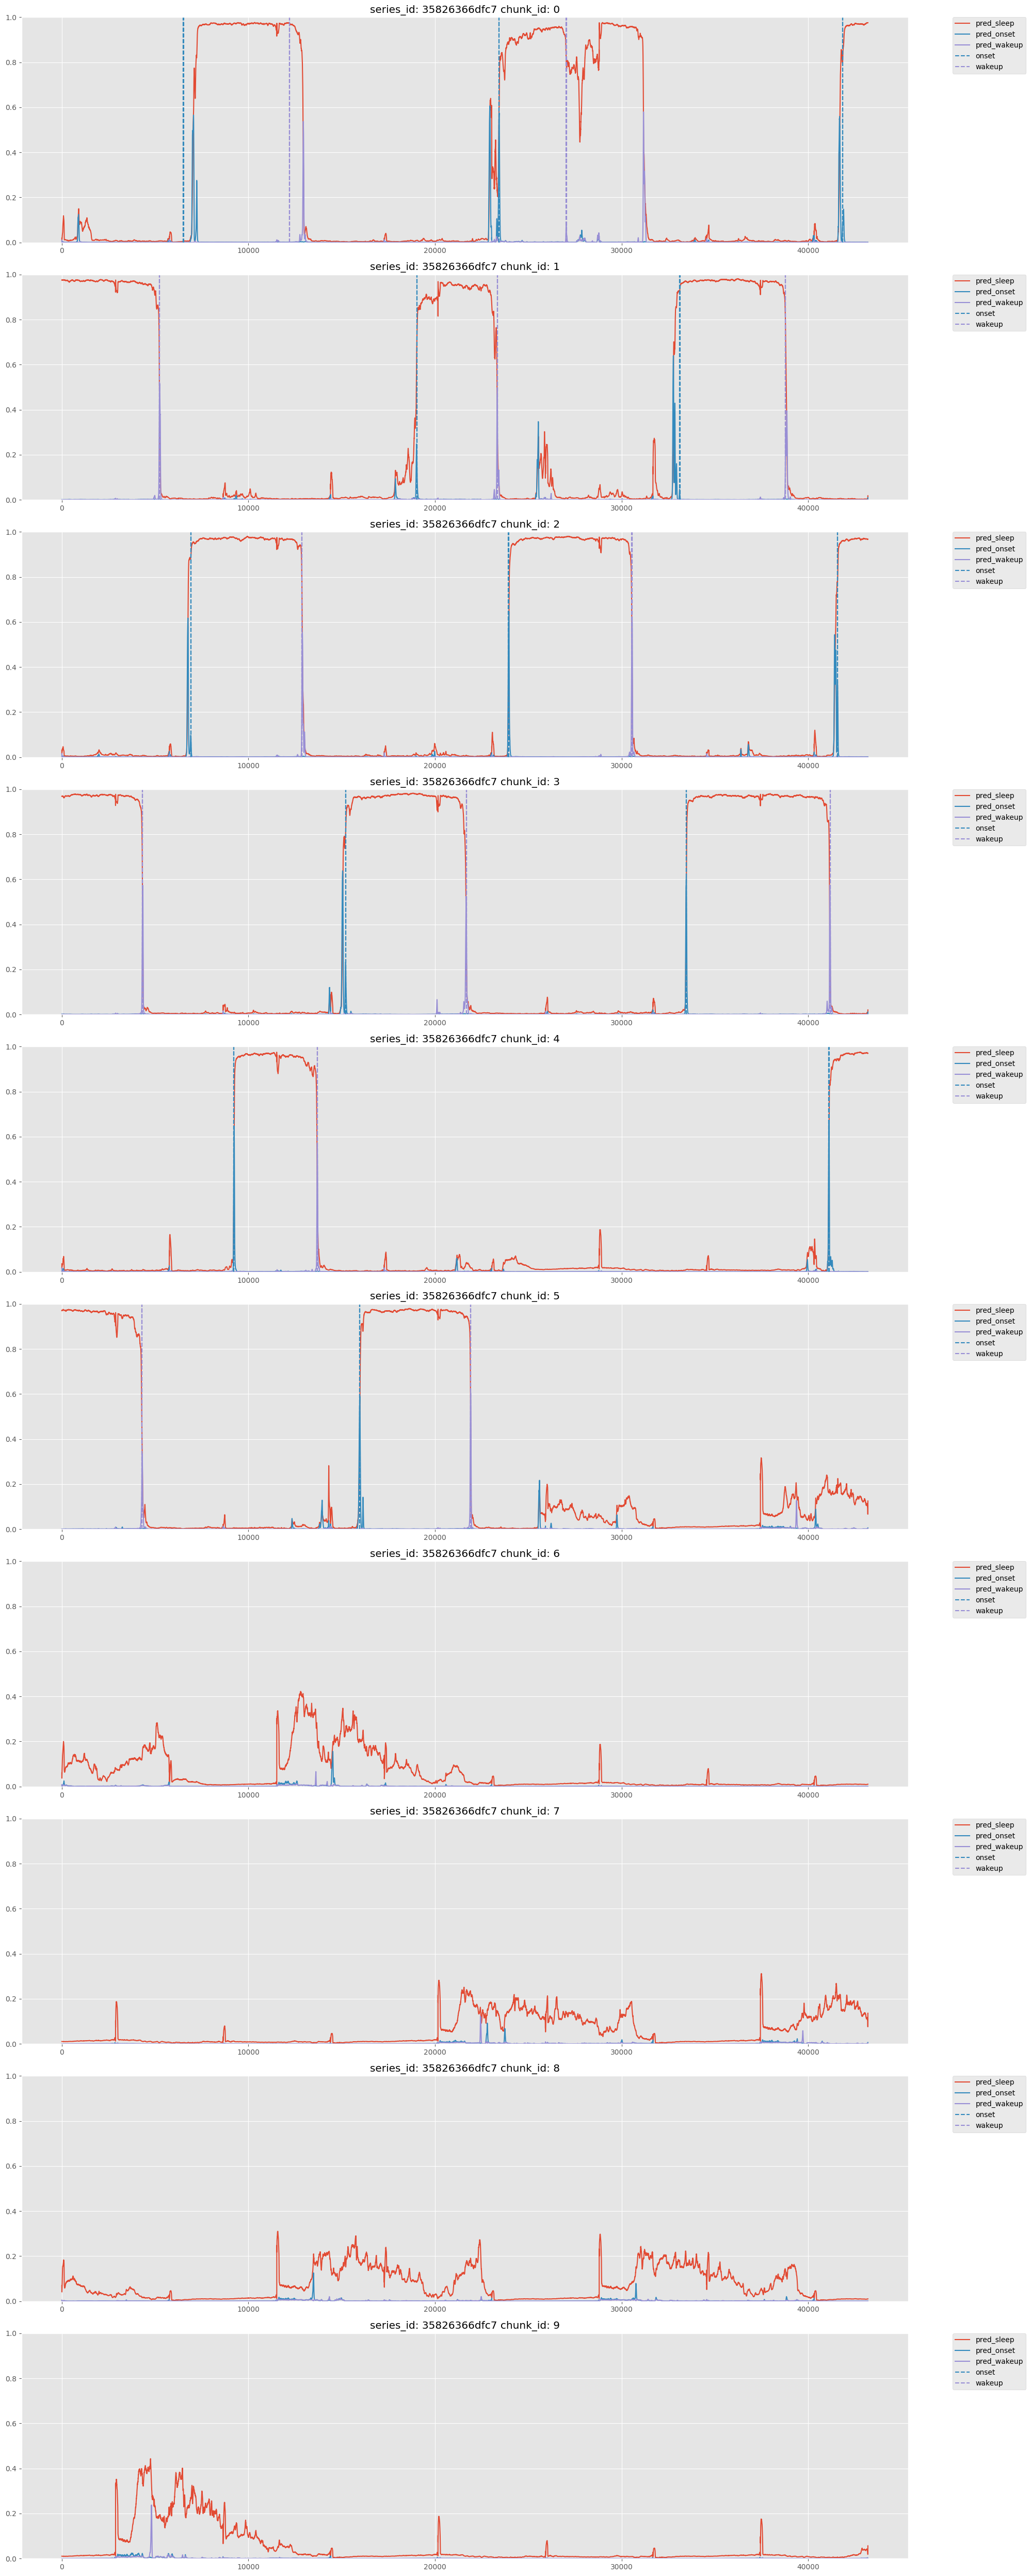

In [8]:
plot_random_sample(keys, preds, labels, num_chunks=10)